# Section 4: Prediction and Analysis

## Contents

- <a href='#Pred_1'>1. Import libraries and data</a>
- <a href='#Pred_2'>2. Predict SVM Models on Test Set </a>
 - <a href='#Pred_2.1'>2.1 SVM Model Trained by Pixel Intensity </a> 
 - <a href='#Pred_2.2'>2.1 SVM Model trained by HOG Descriptor </a>         
- <a href='#Pred_3'>3. Predict MLP Models on Test Set</a>
 - <a href='#Pred_3.1'>3.1 MLP Model Trained by Pixel Intensity </a> 
 - <a href='#Pred_3.2'>3.2 MLP Model trained by HOG Descriptor </a>   

## 1.Import libraries and data <a id='Pred_1'></a> 

In [1]:
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import pandas as pd
import pickle
import torch
from skorch import NeuralNetClassifier
from torch import nn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
import torch.nn.functional as F
import seaborn as sns
pd.set_option('expand_frame_repr', False)

device = 'cpu'

In [2]:
# Create a class to transform image to HOG
# Credit: https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=8,
                 pixels_per_cell=(2, 2),
                 cells_per_block=(2, 2)):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block)

        try:  # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [3]:
# Helper Function to show the first 5 images
# Credit from INM427 Neural Computing Exercise
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img,cmap ='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

In [4]:
# %% Get Current Path
# Get data location path
cwd = os.getcwd()
script_path = cwd + '/'
model_path = script_path + 'Model'
data_path = script_path + 'Data2'
test_path = data_path +'/' + 'mnist_background_random_test.amat'

## 2. Predict SVM Models on Test Set <a id='Pred_2'></a> 

### 2.1 SVM Model Trained by Pixel Intensity <a id='Pred_2.1'></a> 

In [10]:
# Import Data
df_test = np.loadtxt(test_path)

X_test = df_test[:,0:-1]
y_test = df_test[:,-1]

In [13]:
file = model_path + '/'+ 'svm_1_raw_pixel.pkl'
with open(file, 'rb') as file:  
    svm_pixel_mdl = pickle.load(file)

In [14]:
svm_pixel_mdl

SVC(C=10)

In [13]:
# Use the model to predict

y_pred_svm_pixel = svm_pixel_mdl.predict(X_test)

In [18]:
# Get Accuracy Score
accuracy_score_1 = metrics.accuracy_score(y_test, y_pred_svm_pixel)
print('Accuracy of the SVM model trained by pixel intensity is', accuracy_score_1)

Accuracy of the SVM model trained by pixel intensity is 0.84896


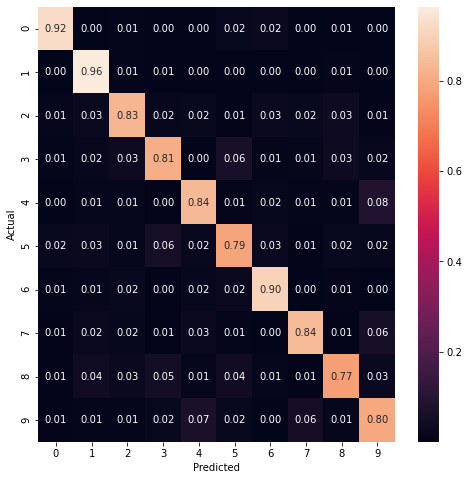

In [35]:
#Plot confusion matrix
y_name = [0,1,2,3,4,5,6,7,8,9]

cm = metrics.confusion_matrix(y_test, y_pred_svm_pixel)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=y_name, yticklabels=y_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### 2.2 SVM Model trained by HOG Descriptor <a id='Pred_2.2'></a> 

In [11]:
# Import Data
df_test = np.loadtxt(test_path)

X_test = df_test[:,0:-1]
X_test = X_test.reshape(X_test.shape[0],28,28)

y_test = df_test[:,-1]

In [6]:
file = model_path + '/'+ 'svm_1_hog.pkl'
with open(file, 'rb') as file:  
    svm_hog_mdl = pickle.load(file)

In [7]:
svm_hog_mdl

Pipeline(steps=[('hogify', HogTransformer()), ('scalify', StandardScaler()),
                ('classify', SVC())])

<b>Warning: The testing of SVM_hog model took a long time(1 hour for me).<br>
Please see the result attached result(in this notebook or html) or consider to rerun this as a             last model.

In [8]:
# Use the model to predict

y_pred_svm_hog = svm_hog_mdl.predict(X_test)

In [12]:
# Get Accuracy Score
accuracy_score_2 = metrics.accuracy_score(y_test, y_pred_svm_hog)
print('Accuracy of the SVM model trained by HOG feature is', accuracy_score_2)

Accuracy of the SVM model trained by HOG feature is 0.81114


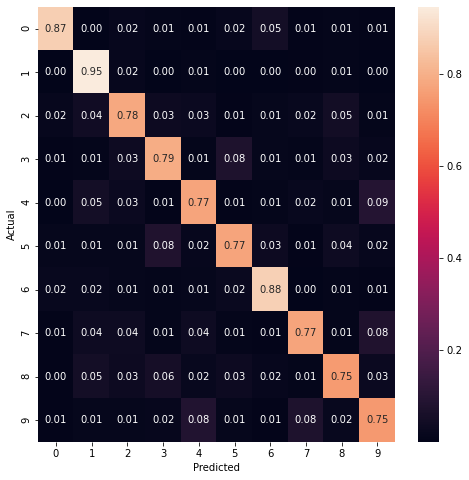

In [13]:
#Plot confusion matrix
y_name = [0,1,2,3,4,5,6,7,8,9]

cm = metrics.confusion_matrix(y_test, y_pred_svm_hog)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=y_name, yticklabels=y_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## 3. Predict MLP Models on Test Set <a id='Pred_3'></a> 

### 3.1 MLP Model Trained by Pixel Intensity <a id='Pred_3.1'></a> 

In [15]:
# %% Set Class
# MLP_1: 1 hidden layer Network

class MLP_1(nn.Module):
    def __init__(self,hidden_dim,function):
        super(MLP_1,self).__init__()
        self.fc1 = nn.Linear(784,hidden_dim)

        if function ==1:
            self.func = nn.ReLU()
        elif function == 2:
            self.func = nn.LeakyReLU()
        elif function == 3:
            self.func = nn.Tanh()
        elif function ==4:
            self.func = nn.Sigmoid()

        self.output = nn.Linear(hidden_dim,10)

    def forward(self,x):

        hidden = self.fc1(x)
        hidden = self.func(hidden)

        out = F.softmax(self.output(hidden), dim = -1)

        return out

In [71]:
# Import Data
df_test = np.loadtxt(test_path)

X_test = df_test[:,0:-1]
y_test = df_test[:,-1]

In [72]:
#Formatting on testing set
X_test  = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(np.array(y_test))
y_test = y_test.type(torch.LongTensor)

In [16]:
file = model_path + '/'+ 'MLP_pixel.pkl'
with open(file, 'rb') as file:  
    mlp_pixel_mdl = pickle.load(file)

In [17]:
mlp_pixel_mdl

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP_1(
    (fc1): Linear(in_features=784, out_features=50, bias=True)
    (func): Tanh()
    (output): Linear(in_features=50, out_features=10, bias=True)
  ),
)

In [77]:
# Use the model to predict

y_pred_mlp_pixel = mlp_pixel_mdl.predict(X_test)

In [78]:
# Get Accuracy Score
accuracy_score_3 = metrics.accuracy_score(y_test, y_pred_mlp_pixel)
print('Accuracy of the SVM model trained by HOG feature is', accuracy_score_3)

Accuracy of the SVM model trained by HOG feature is 0.80162


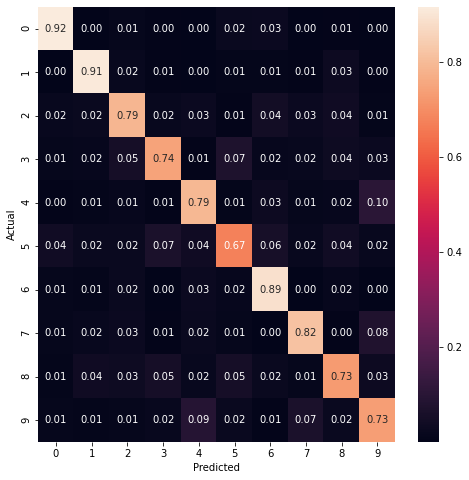

In [79]:
#Plot confusion matrix
y_name = [0,1,2,3,4,5,6,7,8,9]

cm = metrics.confusion_matrix(y_test, y_pred_mlp_pixel)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=y_name, yticklabels=y_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### 3.2 MLP Model trained by HOG Descriptor <a id='Pred_3.2'></a> 

In [5]:
# Redownload the data

df_test = np.loadtxt(test_path)


X_test = df_test[:,0:-1]
y_test = df_test[:,-1]

X_test = X_test.reshape(X_test.shape[0],28,28)


y_test = torch.from_numpy(np.array(y_test))
y_test = y_test.type(torch.LongTensor)

In [6]:
class dataTransform(BaseEstimator, TransformerMixin):
    """
    Transform  numpy datatype to tensor
    """

    def __init__(self,y=None):
        self.y =y
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #def simpleconvert(x):
        #    return 
        return torch.from_numpy(X).float()


In [7]:
# %% Set Class
# MLP_3: 1 hidden layer; with Softmax at output layer

class MLP_3_HOG(nn.Module):
    def __init__(self,hidden_dim,function):
        super(MLP_3_HOG,self).__init__()
        self.fc1 = nn.Linear(5408,hidden_dim)

        if function ==1:
            self.func = nn.ReLU()
        elif function == 2:
            self.func = nn.LeakyReLU()
        elif function == 3:
            self.func = nn.Tanh()
        elif function ==4:
            self.func = nn.Sigmoid()

        self.output = nn.Linear(hidden_dim,10)

    def forward(self,x):
        #Change to tensor
        hidden = self.fc1(x)
        hidden = self.func(hidden)

        out = F.softmax(self.output(hidden), dim = -1)

        return out

In [8]:
file = model_path + '/'+ 'MLP_hog.pkl'
with open(file, 'rb') as file:  
    mlp_hog_mdl = pickle.load(file)

In [9]:
mlp_hog_mdl

Pipeline(steps=[('hogify', HogTransformer()), ('scalify', StandardScaler()),
                ('dataloader', dataTransform()),
                ('classify',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP_3_HOG(
    (fc1): Linear(in_features=5408, out_features=700, bias=True)
    (func): ReLU()
    (output): Linear(in_features=700, out_features=10, bias=True)
  ),
))])

In [10]:
# Use the model to predict

y_pred_mlp_hog = mlp_hog_mdl.predict(X_test)

In [11]:
# Get Accuracy Score
accuracy_score_4 = metrics.accuracy_score(y_test, y_pred_mlp_hog)
print('Accuracy of the MLP model trained by HOG feature is', accuracy_score_4)

Accuracy of the MLP model trained by HOG feature is 0.7855


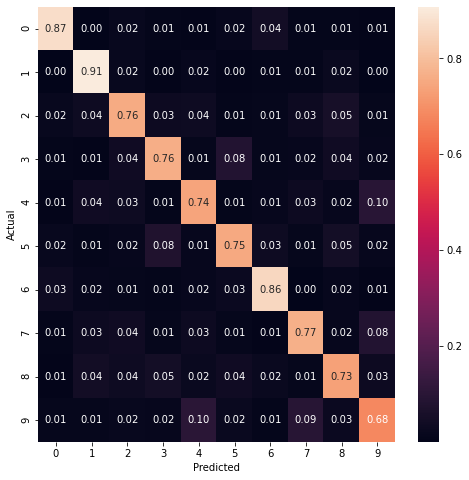

In [12]:
#Plot confusion matrix
y_name = [0,1,2,3,4,5,6,7,8,9]

cm = metrics.confusion_matrix(y_test, y_pred_mlp_hog)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=y_name, yticklabels=y_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)